# 게임 리뷰 데이터 추출하기

In [8]:
! pip install koreanize-matplotlib
! pip install matplotlib
! pip install numpy
! pip install pandas
! pip install openpyxl
! pip install selenium
! pip install webdriver-manager
! pip install wordcloud
! pip install konlpy
! pip install apyori

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## minimap 에서 리뷰를 추출해오는 함수 생성

In [ ]:
def get_review(game):
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from webdriver_manager.chrome import ChromeDriverManager
    from selenium.common.exceptions import TimeoutException
    from selenium.webdriver.common.keys import Keys
    import pyperclip
    import time

    # Chrome 드라이버 설정
    service = Service(ChromeDriverManager().install())
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(service=service, options=options)

    # 게임 리뷰 데이터를 저장할 reviews 리스트 생성
    reviews = []

    try:
        # 웹페이지 URL
        url = f"https://minimap.net/game/{game}/review?l=kr"

        # 웹페이지 로드
        driver.get(url)

        # 로그인 버튼 찾기 및 클릭
        login_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, ".C-button .c-button-item.c-color-primary"))  # 실제 로그인 버튼의 CSS 선택자로 변경 필요
        )
        login_button.click()

        login_button2 = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, ".pop-sign-up .button-w .login-button-w .login-button"))  # 실제 로그인 버튼의 CSS 선택자로 변경 필요
        )
        login_button2.click()

        # 로그인 팝업 창이 나타날 때까지 대기
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "#popupWrapper .popup-wrap-background .popup-dialog-wrap"))  # 실제 팝업 창의 CSS 선택자로 변경 필요
        )

        # 로그인 정보 입력
        id_field = driver.find_element(By.ID, "sign-in-email-input")  # 실제 사용자 이름 필드의 ID로 변경 필요
        pw_field = driver.find_element(By.ID, "sign-in-password-input")  # 실제 비밀번호 필드의 ID로 변경 필요

        pyperclip.copy("lhe9614@gmail.com")
        id_field.send_keys(Keys.CONTROL, 'v')

        pyperclip.copy("!Moon@126419#")
        pw_field.send_keys(Keys.CONTROL, 'v')

        time.sleep(2)

        # 로그인 제출 버튼 클릭
        submit_button = driver.find_element(By.CSS_SELECTOR, ".pop-sign-in .button-w .C-round-button")  # 실제 제출 버튼의 CSS 선택자로 변경 필요
        submit_button.click()

        # 로그인 완료 대기 (예: 특정 요소가 사라질 때까지)
        WebDriverWait(driver, 10).until(
            EC.invisibility_of_element_located((By.CSS_SELECTOR, "#popupWrapper .popup-wrap-background .popup-dialog-wrap"))
        )

        # 로그인 완료 후 페이지가 완전히 로드될 때까지 대기
        WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CLASS_NAME, "review-list"))
        )

        # 리뷰 페이지로 다시 이동
        driver.get(url)

        # 리뷰 컨테이너 요소 찾기
        review_container = WebDriverWait(driver, 20).until(
            EC.presence_of_element_located((By.CLASS_NAME, "review-list"))
        )

        # 컨테이너 끝까지 스크롤
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # 스크롤 반복해서 내리기
        ## 최대 반복 수 설정
        max_cnt = 100

        ## 이전 높이 계산
        old_height = driver.execute_script("return document.body.scrollHeight")

        cnt = 0
        while True:
            ## 스크롤 다운
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

            ## 대기
            time.sleep(0.5)

            ## 새로운 높이 계산
            new_height = driver.execute_script("return document.body.scrollHeight")
            ## 더 이상 스크롤되지 않으면 종료
            if new_height == old_height:
                break
            ## 새로운 높이 계산 값을 이전 높이 변수에 저장장
            old_height = new_height

            ## 카운트 계산
            if cnt == max_cnt:
                break
            cnt += 1

        # 모든 "post-content" 클래스를 가진 div 요소 찾기
        post_contents = driver.find_elements(By.CLASS_NAME, "post-content")

        # 각 "post-content" div의 텍스트 내용 추출
        for post in post_contents:
            review_text = post.text.strip()  # div 내의 모든 텍스트를 가져옴
            reviews.append(review_text)

    except Exception as e:
        print(f"오류 발생, {e}")

    finally:
        # 브라우저 종료
        driver.quit()

    return reviews

## game_list 에 해당하는 게임들의 리뷰 추출

In [ ]:
import pandas as pd

# 게임의 리뷰를 가져오기 위한 game_list 라는 변수들의 list 생성
game_list = {
    ('쿠키런킹덤', 'com-devsisters-ck'),
    ('던전앤파이터', 'dungeon-and-fighters'),
    ('메이플스토리', 'maplestory'),
    ('월드오브워크래프트', 'world-of-warcraft'),
    ('블레이드앤소울', 'blade-soul'),
    ('마비노기', 'mabinogi'),
    ('리그오브레전드', 'league-of-legends'),
    ('아레나오브발러', 'arena-of-valor'),
    ('아레나오브발러', 'com-netmarble-penta-gm'),
    ('도타2', 'dota-2'),
    ('브롤스타즈', 'com-supercell-brawlstars'),
    ('서든어택', 'sudden-attack'),
    ('배틀그라운드', 'playerunknowns-battlegrounds'),
    ('배틀그라운드', 'com-pubg-krmobile'),
    ('오버워치', 'overwatch'),
    ('발로란트', 'valorant'),
    ('클래시오브클랜', 'com-supercell-clashofclans'),
    ('클래시로얄', 'com-supercell-clashroyale-gm'),
    ('스타크래프트', 'starcraft'),
    ('피파온라인', 'fifa-online-4'),
    ('피파23', 'ea-sports-fifa-23'),
    ('캔디크러쉬사가', 'com-king-candycrushsaga'),
    ('마인크래프트', 'minecraft'),
    ('로블록스', 'roblox'),
    ('로블록스', 'com-roblox-client-gm'),
    ('카트라이더', 'kartrider'),
    ('테일즈런너', 'tales-runner'),
    ('크레이지아케이드', 'crazy-arcade'),
    ('모여봐요동물의숲', 'animal-crossing-new-horizons'),
    ('모두의마블', 'com-cjenm-modoomarblekakao-gm'),
    ('포켓몬스터', 'pokemon-scarlet')
}

# 모든 리뷰를 저장할 리스트 생성
all_reviews = []

for game_name, game_id in game_list:
    game_reviews = get_review(game_id)

    for review in game_reviews:
        all_reviews.append({
            "Game": game_name,
            "Review": review
        })

# 리뷰 데이터를 데이터프레임으로 변환
game_reviews_df = pd.DataFrame(all_reviews)

# 데이터프레임 출력
print(game_reviews_df)

# CSV 파일로 저장
game_reviews_df.to_csv('game_reviews.csv', index=False)



      Game                                             Review
0     로블록스                     이 게임 하나의 모든 장르에 게임이 있어서 정말 추천함
1     로블록스                                         진짜 할 거 없어요
2     로블록스  게임이라기 보단 게임들이 모여있는 플렛폼에 더 가깝다.\n하지만 게임 저작권 문제해...
3     로블록스  진짜 모든 사람에게 추천드려요!\n왜냐하면 모든 장르의 게임이 다있거든요!\n 컴퓨...
4     로블록스       와!로블록스아시는구나!겁나갓겜입니다\n같은 이미지가 있어서 그렇지 생각보단 ㄱㅊ
..     ...                                                ...
687  테일즈런너  얼라시절 정말 열심히 했었다\n그때쯤 유키가 신캐였던가 그랬지\n난 컨트롤이 그때도...
688  테일즈런너  누구는 추억 보정 잔뜩 들어간 게임이라고 말하지만\n그 당시 이 게임이 가진 매력과...
689  테일즈런너                                             재밌는 테런
690  테일즈런너                                                재밋다
691  테일즈런너               똥망겜이라고 하지만 누구보다 열심히 플레이 했던\n 어린 나...

[692 rows x 2 columns]


## 형태소 분석기를 이용하여 리뷰의 단어 추출

In [1]:
import pandas as pd

# 데이터 불러오기
# data_review = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/game_reviews.csv')
data_review = pd.read_csv('../data/game_reviews.csv')
data_review

,Game,Review
0,피파23,"라스트 FIFA, 그 이름"
1,피파23,EA FC 24 티저 나오자마자 별로 기대 안되길래 언젠간 해봐야지 했던 축구 게임...
2,피파23,엑박판으로 플레이 중이지만 PC판은 실행이 안됨.\n EA 패망의 서막을 알리는 게...
3,피파23,축구는 종교다.\nFIFA 23 | Official Launch Trailer | ...
4,피파23,최고의 손님 접대용 게임.\n하이퍼모션2가 적용되면서 움직임의 사실성이 훨씬 좋아졌...
...,...,...
1737,발로란트,재미는 있다... 그런데 중간중간 쉬는 텀없이 빠르게 진행되서 그런지 5판~10판 ...
1738,발로란트,오우 싸발적이고
1739,발로란트,역시 게임은 처음 나왔을 때가 젤 재밌다..\n클로즈베타때 그렇게 했는데\n정식출시...
1740,발로란트,라이엇이 만든 FPS\n롤이랑 세계관이 다르지만 꽤 잘 만들긴 했다.\n우리나라에서...


In [2]:
# difficulty 열 추가 함수
def assign_difficulty(game):
    if game == '던전앤파이터':
        return 3.1
    elif game == '도타2':
        return 4
    elif game == '로블록스':
        return 2.5
    elif game == '리그오브레전드':
        return 3.59
    elif game == '마비노기':
        return 3.55
    elif game == '마인크래프트':
        return 2.83
    elif game == '메이플스토리':
        return 2.93
    elif game == '모여봐요동물의숲':
        return 1.94
    elif game == '발로란트':
        return 3.72
    elif game == '배틀그라운드':
        return 3.86
    elif game == '브롤스타즈':
        return 2.96
    elif game == '블레이드앤소울':
        return 3.1
    elif game == '스타크래프트':
        return 3.69
    elif game == '아레나오브발러':
        return 3.07
    elif game == '오버워치':
        return 3.05
    elif game == '월드오브워크래프트':
        return 3.01
    elif game == '캔디크러쉬사가':
        return 3.51
    elif game == '클래시로얄':
        return 3.44
    elif game == '클래시오브클랜':
        return 3.17
    elif game == '포켓몬스터':
        return 2.18
    else:
        return ''

In [3]:
# genre 열 추가 함수
def assign_genre(game):
    if game in ['로블록스', '마인크래프트']:
        return '샌드박스'
    elif game in ['도타2', '리그오브레전드', '아레나오브발러']:
        return 'AOS'
    elif game in ['발로란트', '배틀그라운드', '브롤스타즈', '서든어택', '오버워치']:
        return 'FPS'
    elif game in ['스타크래프트', '클래시로얄', '클래시오브클랜']:
        return 'RTS'
    elif game in ['던전앤파이터', '마비노기', '매이플스토리', '블레이드앤소울', '월드오브워크래프트', '쿠키런킹덤', '포켓몬스터']:
        return 'RPG'
    elif game in ['캔디크러쉬사가']:
        return '캐주얼'
    elif game in ['피파23', '피파온라인']:
        return '스포츠'
    else:
        return '기타'

In [4]:
# age 열 추가 함수
def assign_age(game):
    if game in ['로블록스', '모여봐요동물의숲', '브롤스타즈', '쿠키런킹덤', '포켓몬스터']:
        return '06_12'
    elif game in ['마인크래프트', '모두의마블', '발로란트', '오버워치', '클래시로얄', '클래시오브클랜', '피파23', '피파온라인']:
        return '13_18'
    elif game in ['리그오브레전드', '테일즈런너']:
        return '19_24'
    elif game in ['던전앤파이터', '도타2', '마비노기', '메이플스토리', '배틀그라운드', '블레이드앤소울', '서든어택', '스타크래프트', '월드오브워크래프트', '카트라이더', '캔디크러쉬사가', '크레이지아케이드', '아레나오브발러']:
        return '25_29'

In [5]:
# 새로운 열 추가
data_review['difficulty'] = data_review['Game'].apply(assign_difficulty)
data_review['genre'] = data_review['Game'].apply(assign_genre)
data_review['age'] = data_review['Game'].apply(assign_age)

In [6]:
data_review

,Game,Review,difficulty,genre,age
0,피파23,"라스트 FIFA, 그 이름",,스포츠,13_18
1,피파23,EA FC 24 티저 나오자마자 별로 기대 안되길래 언젠간 해봐야지 했던 축구 게임...,,스포츠,13_18
2,피파23,엑박판으로 플레이 중이지만 PC판은 실행이 안됨.\n EA 패망의 서막을 알리는 게...,,스포츠,13_18
3,피파23,축구는 종교다.\nFIFA 23 | Official Launch Trailer | ...,,스포츠,13_18
4,피파23,최고의 손님 접대용 게임.\n하이퍼모션2가 적용되면서 움직임의 사실성이 훨씬 좋아졌...,,스포츠,13_18
...,...,...,...,...,...
1737,발로란트,재미는 있다... 그런데 중간중간 쉬는 텀없이 빠르게 진행되서 그런지 5판~10판 ...,3.72,FPS,13_18
1738,발로란트,오우 싸발적이고,3.72,FPS,13_18
1739,발로란트,역시 게임은 처음 나왔을 때가 젤 재밌다..\n클로즈베타때 그렇게 했는데\n정식출시...,3.72,FPS,13_18
1740,발로란트,라이엇이 만든 FPS\n롤이랑 세계관이 다르지만 꽤 잘 만들긴 했다.\n우리나라에서...,3.72,FPS,13_18


In [30]:
# CSV 파일로 저장
data_review.to_csv('game_reviews_all.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 명사만 출력하기

In [8]:
from konlpy.tag import Kkma
from collections import Counter
import pandas as pd
import re

# 데이터 불러오기
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/game_reviews_all.csv')
data = data_review.copy()

# 모든 리뷰를 담을 딕셔너리 생성
game_nouns = {}

# Kkma 형태소 분석기 초기화
kkma = Kkma()

# 불용어 지정
stopwords = ["때문", "그때", "정말", "매우", "게임", "하다", "이건"]

# 게임별로 리뷰 분석
for game in data['Game'].unique():
    # 해당 게임의 모든 리뷰 추출
    game_reviews = data[data['Game'] == game]['Review']

    # 모든 리뷰에서 명사 추출
    nouns_list = []
    for review in game_reviews:
        if isinstance(review, str):
            review_edit = re.sub("[^0-9a-zA-Z가-힣\\s+]", "", review)
            review_edit_pos = kkma.pos(review_edit)
            sub_list = []
            for word, pos in review_edit_pos:
                if len(word) == 1 or word in stopwords:
                    continue
                if pos.startswith('N'):  # 태그가 N으로 시작하는 모든 명사 추출
                    sub_list.append(word)
            nouns_list.extend(sub_list)

    # 게임별 명사 리스트 저장
    game_nouns[game] = nouns_list

    # 그래픽 관련 추가할 명사 : 그래픽, 화면, 화질, 퀄리티, 비디오, 모션
    # 명사+동사 리뷰도 뽑기


    print(f"{game} 의 리뷰의 등장하는 명사> ")
    print(set(nouns_list))
    print("")

print(game_nouns)

피파23 의 리뷰의 등장하는 명사> 
{'사실성', '그동안', '하이퍼', '버프', '친절', '저지', '입문', '한데', '무한', '드리블', '한지', '결승', '골드만', '트로피', '자연', '프로페셔널', '방향', '사용', '24', '오프', '재미', '터키', '콘솔', '라인', '이적', '패스', '월드컵', '사이', '손님', '유저', '감상', '매칭', '오버', '동안', '한국어', '한글', '난이도', '정도', '토너먼트', '기만', '기본', '스포츠', '사이드', '이름', '현질', '종교', '메이트', '화도', '47', '라스트', '버전', '요구', '베타', '사람', '마이', '만큼', '수급', '결제', '하향', '스페셜', '실망', '하지', '수십', '리그', '니들', '출시', '중독', '축구', '그래픽', '작품', '마지막', '내가', '은퇴', '카드', '방치', '다음', '야구', '개인기', '처음', '세미', '지인', '맞추기', '스케이트', '좌절감', '계속', '클로즈', '22', '부상', '이후', '주말', '목적', '특유', '개새끼', '유도', '충격', '콘돔', '발전', '혁신', '인상적', '수준', '난이', '플레이', '적용', '개월', '경기', '마음', '플레이어', '감사', '한번', '전환', '체감', '개선', '클럽', '그것', '불편', '내기', '동기', '오류', '인칭', '선수', '만족', '메타', '최대', '온라인', '보임', '도로', '사실', '21', '장점', '커리어', '딜레이', '조금', '고무적', '아이즈', '거짓말', '프로', '부분', '이제', '필요', '평가', '악랄', '싱글', '시스템', '구입', '기준', '기대', '슈팅', '역사', '접대용', '시간', '참고', '모션', '결국', '시기', '쇼케이스', '안됨', 

KeyboardInterrupt: 

## age별 그래픽에 관련된 리뷰만 추출하기

In [9]:
# 데이터 불러오기
# data_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/game_reviews_all.csv')
data_all = data_review.copy()



연령대: 13_18
장바구니 분석 결과:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 47732 (\N{HANGUL SYLLA

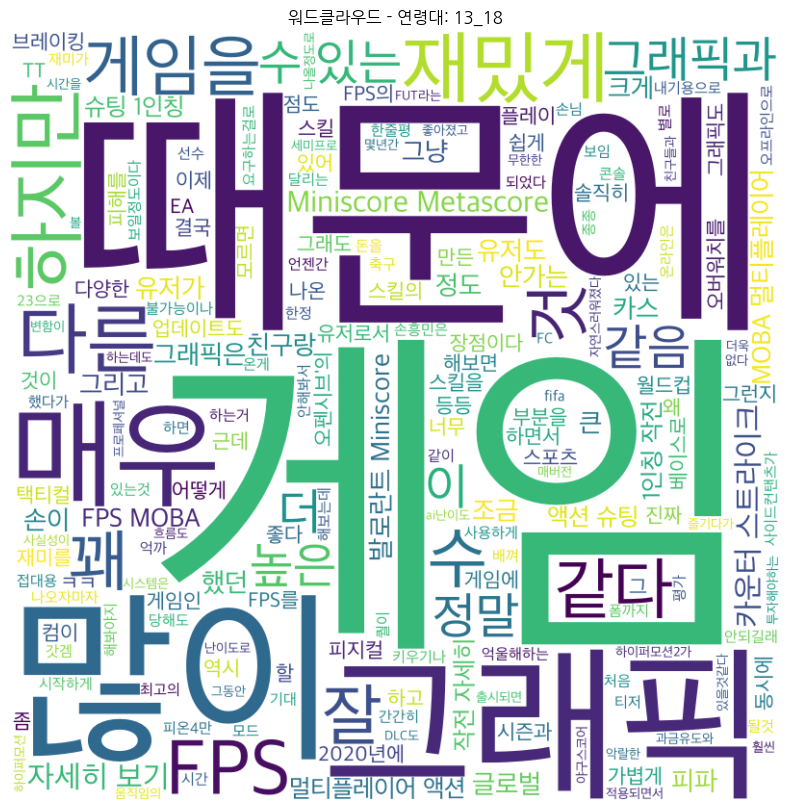


연령대: 25_29
장바구니 분석 결과:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 47680 (\N{HANGUL SYLLABLE MEOL}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 48120 (\N{HANGUL SYLL

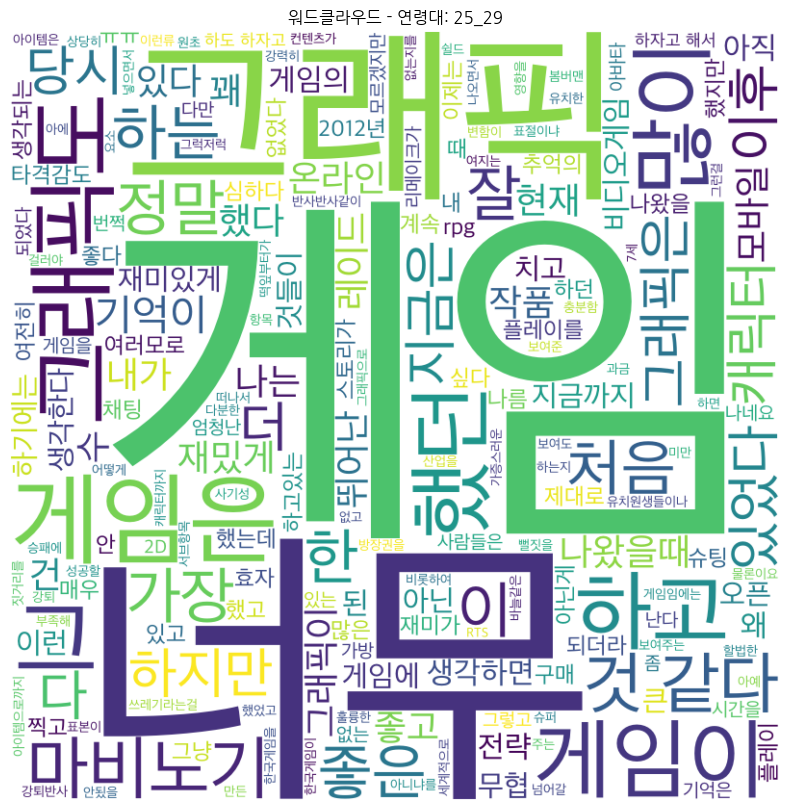


연령대: 06_12
장바구니 분석 결과:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence]
Index: []


/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 54589 (\N{HANGUL SYLLABLE PIG}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.savefig(f"network_analysis_{age_group}.png")
/var/folders/91/vlsqpdb969qcnch2t3_wcv6c0000gn/T/ipykernel_18816/3180215666.py:61: UserWarning: Glyph 47732 (\N{HANGUL SYLLA

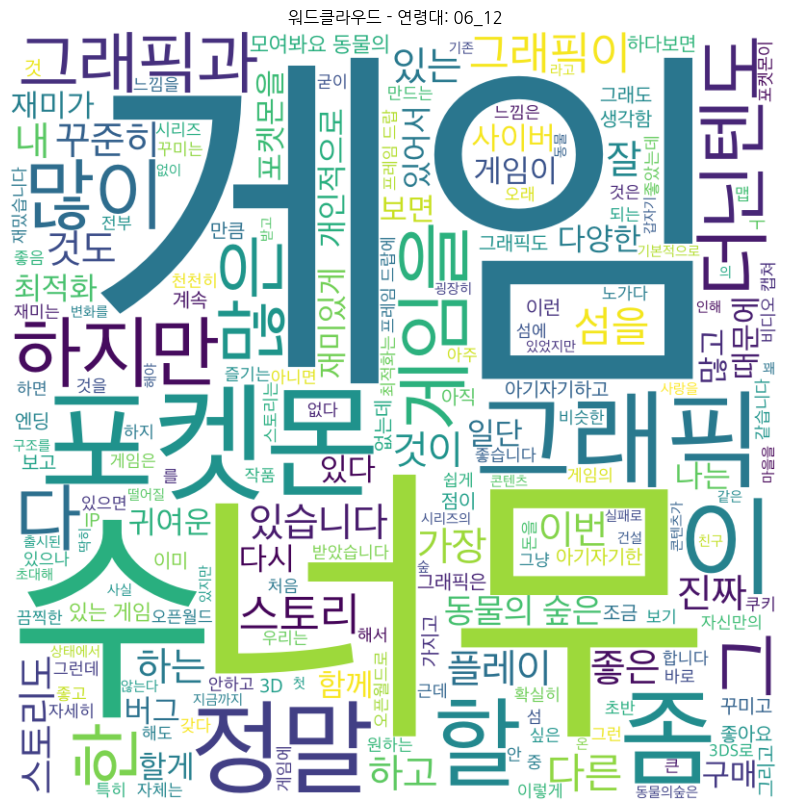

In [10]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import matplotlib.pyplot as plt
import koreanize_matplotlib
from wordcloud import WordCloud
from collections import Counter

# data_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/game_reviews_all.csv')
data_all = data_review.copy()

# 키워드 리스트
keywords = ["그래픽", "화질", "프레임", "멀미", "화면", "비디오", "모션", "퀄리티", "3D", "2D", "3인칭", "1인칭"]

# 키워드가 포함된 리뷰만 필터링
data_all['contains_keyword'] = data_all['Review'].apply(lambda x: any(keyword in str(x) for keyword in keywords))
df_filtered = data_all[data_all['contains_keyword']]

font_path = "/System/Library/Fonts/Supplemental/AppleSDGothicNeo.ttc"

# 연령대별로 분석 수행
for age_group in df_filtered['age'].unique():
    print(f"\n연령대: {age_group}")
    age_df = df_filtered[df_filtered['age'] == age_group]

    # 1. 장바구니 분석
    transactions = []
    for review in age_df['Review']:
        transaction = [keyword for keyword in keywords if keyword in str(review)]
        transactions.append(transaction)

    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5, num_itemsets=len(data_all))

    print("장바구니 분석 결과:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence']])

    # 2. 네트워크 분석
    G = nx.Graph()
    for transaction in transactions:
        for i in range(len(transaction)):
            for j in range(i+1, len(transaction)):
                if G.has_edge(transaction[i], transaction[j]):
                    G[transaction[i]][transaction[j]]['weight'] += 1
                else:
                    G.add_edge(transaction[i], transaction[j], weight=1)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)

    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(f"키워드 네트워크 분석 - 연령대: {age_group}")
    plt.savefig(f"network_analysis_{age_group}.png")
    plt.close()

     # 3. 워드클라우드
    text = ' '.join(age_df['Review'].astype(str))
    wordcloud = WordCloud(width=800, height=800, background_color='white', font_path=font_path).generate(text)

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"워드클라우드 - 연령대: {age_group}")
    plt.show()
    # plt.savefig(f"wordcloud_{age_group}.png")
    # plt.close()

In [ ]:
game_reviews

{'블레이드앤소울': [{'Review': "오픈 초창기에는 정말 재미있게 했다\n액션과 그래픽, 캐릭터 커스터마이징 시스템도 훌륭했고, 그때 까지 출시된 타 회사의 무협 게임들 중, 무협의 느낌을 가장 잘 살린 연출을 보여줬던 작품 이었다\n한타 치고 다음 작품을 노리는 콘솔 패키지 게임이 아닌, 추가와 확장과 패치 등으로 장기간 우려먹어야 하는 온라인 게임의 특성 상, 아무리 초창기에 좋은 평을 받았다고 한 들 이후 게임에 적용되는 모든 것들이 '좋은 것' 이라고 할 수는 없지만\n가장 큰 문제는 이런 빛나는 재능을 가진 아이를, 무능력 해지고 돈만 밝히는 졸부 부모가 점점 망가뜨려 갔다는 점이 아닐까 생각한다\n여러모로 아쉽기만한 작품",
   'Keywords': ['그래픽']},
  {'Review': '장점: 12년도 3d mmo rpg 주자로써 뛰어난 그래픽을 가지고 있던 게임이다\n단점 : 과금유도가 매~우 심하다',
   'Keywords': ['그래픽']},
  {'Review': '2012년 여름 방학 어느 날인가 블레이드앤소울이 출시되었다.\n몇 년을 기다렸던 게임이라 서버 오픈 시간에 맞춰 PC 방에서 대기를 타고 있다가 서버가 열리자 마자 들어갔다.\n그리고 그 날 10시간 정도 피씨방에서 라면 먹고 단무지 씹고 닥터페퍼와 코카콜라를 마셔가면서 플레이를 했다.\n블레이드앤소울의 초반은 정말 끝내준다.\n그 감각을 후반까지 유지하지 못하는 게 아쉬울 뿐.\n특히 2012년 업데이트 되었던 부분이 지나면, 그 이후로는 꽤 퀄리티가 떨어진다.\n하지만 올해 12월 부분유료화 전환을 하면서 여러모로 바뀌었고, 나도 복귀했다.\n블레이드앤소울은 스토리가 궁금해서라도 스토리가 확장될 때마다 하게 되더라.',
   'Keywords': ['퀄리티']},
  {'Review': '한 때 엄청 푹 빠져서 그 때의 시간들을 모조리 쏟아부었던 추억의 게임 (필자는 무료화 직후)\n하지만, 각성 업데이트와 계속되는 파워 인플레이션, 기존 던전들의 몰락에 지

In [ ]:
game_reviews.keys()

dict_keys(['블레이드앤소울', '배틀그라운드', '로블록스', '마비노기', '크레이지아케이드', '이사만루', '쿠키런킹덤', '모여봐요동물의숲', '스타크래프트', '서든어택', '마인크래프트', '발로란트', '카트라이더', '포켓몬스터', '피파'])

### 장바구니 분석

In [ ]:
# 한글 폰트 설치
!apt-get update
!apt-get install fonts-nanum* -y

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,448 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/ma

### 네트워크 분석

## 명사 + 동사 출력하기

In [ ]:
game_nouns.keys()

dict_keys(['로블록스', '모두의마블', '블레이드앤소울', '포켓몬스터', '피파', '리그오브레전드', '슈퍼스타', '배틀그라운드', '마인크래프트', '스타크래프트', '모여봐요동물의숲', '발로란트', '브롤스타즈', '이사만루', '월드오브워크래프트', '클래시오브클랜', '카트라이더', '던전앤파이터', '캔디크러쉬사가', '펜타스톰', '도타2', '서든어택', '메이플스토리', '마비노기', '크레이지아케이드', '쿠키런킹덤', '클래시로얄', '오버워치', '마구마구', '테일즈런너'])

In [ ]:
# apriori
from apyori import apriori

# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/game_reviews_all.csv')

game_reviews = data[data['Game'] == game]['Review']

result = list(apriori(game_reviews))
data = pd.DataFrame(result)
data

# result = list(apriori(game_nouns_values))
# print(apriori(game_nouns_values))
# data = pd.DataFrame(result)
# data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'game' is not defined

## 그래픽에 대한 리뷰 추출

## 분위기에 대한 리뷰 추출

# 게임별 리뷰의 워드클라우드

In [ ]:
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 한글 폰트 설정 (맥OS 기준, 윈도우의 경우 적절한 폰트 경로로 변경 필요)
font_path = 'C:/Windows/Fonts/HMFMOLD.TTF'

# 각 게임별로 워드클라우드 생성
for game, nouns in game_nouns.items():
    # 단어 빈도수 계산
    word_counts = Counter(nouns)

    # 마스크 이미지 가져오기
    mask_img = np.array(Image.open("./images/console.png"))

    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path=font_path,
        width=512,
        height=512,
        mask=mask_img,
        background_color='white',
        colormap="twilight"
    ).generate_from_frequencies(word_counts)

    # 워드클라우드 그리기
    plt.figure(figsize=(16, 16))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{game} 리뷰 워드클라우드 분석")
    # plt.show()

    # 이미지 저장
    plt.savefig(f"{game}_wordcloud.png")
    plt.close()

print("모든 게임의 워드클라우드가 생성되었습니다.")


모든 게임의 워드클라우드가 생성되었습니다.
